# Exercise 2 - AWS data modelling using pyspark

In [1]:
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

In [4]:
from pyspark.mllib.random import RandomRDDs

In [5]:
import math 

In [6]:
from pyspark.sql.types import *

In [7]:
spark = SparkSession.builder \
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
  .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/15 05:39:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/04/15 05:39:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/04/15 05:39:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/04/15 05:39:39 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [8]:
random_walk_input = spark.read.format("bigquery").option(
"table", "umc-dsa-8430-sp2022.nkg7b3_m6_natality.aws_m4").load()

In [9]:
random_walk_input.createOrReplaceTempView("rdm_walk")

In [10]:
sql_qry = """
SELECT Year_ID, SC_Commodity_Desc,  SC_Frequency_Desc, Timeperiod_ID,Timeperiod_Desc, Amount

 FROM rdm_walk 
 where ( Year_ID >= 2000 and SC_Commodity_Desc = 'Oats' and SC_Frequency_Desc = 'Monthly'and SC_Group_ID = 1)
"""

In [11]:
rdm_walk_clean = spark.sql(sql_qry)

In [12]:
rdm_walk_clean.show(5)

+-------+-----------------+-----------------+-------------+---------------+------+
|Year_ID|SC_Commodity_Desc|SC_Frequency_Desc|Timeperiod_ID|Timeperiod_Desc|Amount|
+-------+-----------------+-----------------+-------------+---------------+------+
|   2009|             Oats|          Monthly|            4|            Apr|  2.37|
|   2010|             Oats|          Monthly|            4|            Apr|  2.25|
|   2011|             Oats|          Monthly|            4|            Apr|  3.54|
|   2012|             Oats|          Monthly|            4|            Apr|  3.84|
|   2013|             Oats|          Monthly|            4|            Apr|  4.43|
+-------+-----------------+-----------------+-------------+---------------+------+
only showing top 5 rows



In [13]:
# rdm_walk_clean = rdm_walk_clean.withColumn('Days',\
#                                            when(rdm_walk_clean.Timeperiod_ID == 8,lit(31)) \
#                                            .when(rdm_walk_clean.Timeperiod_ID%2 != 0, lit(31)) \
#                                            .otherwise(lit(30)) \
#                                           )


rdm_walk_clean = rdm_walk_clean.withColumn('Day',lit(1))

In [14]:
rdm_walk_clean = rdm_walk_clean.withColumn("Date_placeholder",concat_ws("-",col("Year_ID"),col("Timeperiod_ID"),
                                                            col("Day")).cast("date"))
rdm_walk_clean.show(5)


+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+
|Year_ID|SC_Commodity_Desc|SC_Frequency_Desc|Timeperiod_ID|Timeperiod_Desc|Amount|Day|Date_placeholder|
+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+
|   2009|             Oats|          Monthly|            4|            Apr|  2.37|  1|      2009-04-01|
|   2010|             Oats|          Monthly|            4|            Apr|  2.25|  1|      2010-04-01|
|   2011|             Oats|          Monthly|            4|            Apr|  3.54|  1|      2011-04-01|
|   2012|             Oats|          Monthly|            4|            Apr|  3.84|  1|      2012-04-01|
|   2013|             Oats|          Monthly|            4|            Apr|  4.43|  1|      2013-04-01|
+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+
only showing top 5 rows



In [15]:
rdm_walk_clean = rdm_walk_clean.withColumn('End_of_Month',last_day(rdm_walk_clean.Date_placeholder))

In [16]:
rdm_walk_clean.show(5)

+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+
|Year_ID|SC_Commodity_Desc|SC_Frequency_Desc|Timeperiod_ID|Timeperiod_Desc|Amount|Day|Date_placeholder|End_of_Month|
+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+
|   2009|             Oats|          Monthly|            4|            Apr|  2.37|  1|      2009-04-01|  2009-04-30|
|   2010|             Oats|          Monthly|            4|            Apr|  2.25|  1|      2010-04-01|  2010-04-30|
|   2011|             Oats|          Monthly|            4|            Apr|  3.54|  1|      2011-04-01|  2011-04-30|
|   2012|             Oats|          Monthly|            4|            Apr|  3.84|  1|      2012-04-01|  2012-04-30|
|   2013|             Oats|          Monthly|            4|            Apr|  4.43|  1|      2013-04-01|  2013-04-30|
+-------+-----------------+-----------------+-------------+-----

In [17]:
rdm_walk_clean.__class__

pyspark.sql.dataframe.DataFrame

In [18]:
rdm_walk_clean.dtypes

[('Year_ID', 'bigint'),
 ('SC_Commodity_Desc', 'string'),
 ('SC_Frequency_Desc', 'string'),
 ('Timeperiod_ID', 'bigint'),
 ('Timeperiod_Desc', 'string'),
 ('Amount', 'double'),
 ('Day', 'int'),
 ('Date_placeholder', 'date'),
 ('End_of_Month', 'date')]

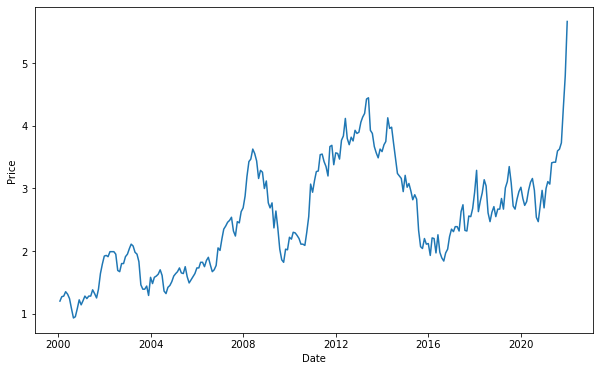

In [19]:
rdm_walk_clean = rdm_walk_clean.orderBy(asc("End_of_Month") )

width = 10
height = 6
data = rdm_walk_clean.toPandas()
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(1,1,1)
ax.plot(data.End_of_Month, data.Amount)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
# ax.set_xlabel('Date')
# ax.set_ylabel('price ($)')
plt.show()


In [20]:
win = Window.partitionBy('SC_Commodity_Desc').orderBy('End_of_Month')
rdm_walk_clean = rdm_walk_clean.withColumn('perc_change', round(rdm_walk_clean.Amount - lag(rdm_walk_clean['Amount'],1).over(win)/100,4))

In [21]:
rdm_walk_clean.show(10)

+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+-----------+
|Year_ID|SC_Commodity_Desc|SC_Frequency_Desc|Timeperiod_ID|Timeperiod_Desc|Amount|Day|Date_placeholder|End_of_Month|perc_change|
+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+-----------+
|   2000|             Oats|          Monthly|            1|            Jan|   1.2|  1|      2000-01-01|  2000-01-31|       null|
|   2000|             Oats|          Monthly|            2|            Feb|  1.27|  1|      2000-02-01|  2000-02-29|      1.258|
|   2000|             Oats|          Monthly|            3|            Mar|  1.28|  1|      2000-03-01|  2000-03-31|     1.2673|
|   2000|             Oats|          Monthly|            4|            Apr|  1.35|  1|      2000-04-01|  2000-04-30|     1.3372|
|   2000|             Oats|          Monthly|            5|            May|  1.31|  1|      2000-

In [22]:
rdm_walk_clean = rdm_walk_clean.na.fill(value=0,subset=["perc_change"])

In [23]:
rdm_walk_clean.show(10)

+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+-----------+
|Year_ID|SC_Commodity_Desc|SC_Frequency_Desc|Timeperiod_ID|Timeperiod_Desc|Amount|Day|Date_placeholder|End_of_Month|perc_change|
+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+-----------+
|   2000|             Oats|          Monthly|            1|            Jan|   1.2|  1|      2000-01-01|  2000-01-31|        0.0|
|   2000|             Oats|          Monthly|            2|            Feb|  1.27|  1|      2000-02-01|  2000-02-29|      1.258|
|   2000|             Oats|          Monthly|            3|            Mar|  1.28|  1|      2000-03-01|  2000-03-31|     1.2673|
|   2000|             Oats|          Monthly|            4|            Apr|  1.35|  1|      2000-04-01|  2000-04-30|     1.3372|
|   2000|             Oats|          Monthly|            5|            May|  1.31|  1|      2000-

In [24]:
rdm_walk_clean.groupby("Year_ID").count().orderBy('Year_ID').show()

+-------+-----+
|Year_ID|count|
+-------+-----+
|   2000|   12|
|   2001|   12|
|   2002|   12|
|   2003|   12|
|   2004|   12|
|   2005|   12|
|   2006|   12|
|   2007|   12|
|   2008|   12|
|   2009|   12|
|   2010|   12|
|   2011|   12|
|   2012|   12|
|   2013|   12|
|   2014|   12|
|   2015|   12|
|   2016|   12|
|   2017|   12|
|   2018|   12|
|   2019|   12|
+-------+-----+
only showing top 20 rows



In [25]:
schema = StructType([
   StructField('yearly_vol', FloatType(), True),
    StructField('year', IntegerType(), True)])
df_year_vol = spark.createDataFrame([], schema)

In [26]:
years = rdm_walk_clean.select("Year_ID").distinct().orderBy('Year_ID').toPandas()['Year_ID']
    
for i in years:
    temp = rdm_walk_clean.filter(rdm_walk_clean.Year_ID<=i)
    temp = temp.agg({'perc_change': 'stddev'})
    temp = temp.withColumn("year", lit(i))
    df_year_vol = df_year_vol.union(temp)

In [27]:
df_year_vol.show()

+-------------------+----+
|         yearly_vol|year|
+-------------------+----+
|0.36023824723747383|2000|
|0.34450606647337345|2001|
|0.41636642824731707|2002|
| 0.4049616991290961|2003|
| 0.3649272820489249|2004|
| 0.3369365148149563|2005|
| 0.3294039342734113|2006|
|0.42049078129823236|2007|
| 0.6418921000628162|2008|
| 0.6312759808248577|2009|
| 0.6228007132054262|2010|
| 0.7220098337492321|2011|
| 0.8312660513579256|2012|
| 0.9170403749943787|2013|
| 0.9401537733844063|2014|
| 0.9162536346933262|2015|
| 0.8932564847206041|2016|
| 0.8695984475863401|2017|
| 0.8524466594424117|2018|
| 0.8386992886061765|2019|
+-------------------+----+
only showing top 20 rows



In [28]:
rdm_walk_clean = rdm_walk_clean.join(df_year_vol,rdm_walk_clean.Year_ID == df_year_vol.year,"left" ).orderBy(desc("Year_ID"))

In [29]:
rdm_walk_clean.show(5)

+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+-----------+-----------------+----+
|Year_ID|SC_Commodity_Desc|SC_Frequency_Desc|Timeperiod_ID|Timeperiod_Desc|Amount|Day|Date_placeholder|End_of_Month|perc_change|       yearly_vol|year|
+-------+-----------------+-----------------+-------------+---------------+------+---+----------------+------------+-----------+-----------------+----+
|   2021|             Oats|          Monthly|            4|            Apr|  3.41|  1|      2021-04-01|  2021-04-30|     3.3793|0.863220238831348|2021|
|   2021|             Oats|          Monthly|            2|            Feb|  3.11|  1|      2021-02-01|  2021-02-28|       3.08|0.863220238831348|2021|
|   2021|             Oats|          Monthly|            3|            Mar|  3.07|  1|      2021-03-01|  2021-03-31|     3.0389|0.863220238831348|2021|
|   2021|             Oats|          Monthly|            1|            Jan|   3.0|  1|  

In [30]:
random_walk_df = rdm_walk_clean.toPandas()


In [31]:
year_vol_df = df_year_vol.toPandas()

In [94]:
df_year_vol.filter(df_year_vol.yearly_vol<0).show()

+----------+----+
|yearly_vol|year|
+----------+----+
+----------+----+



In [32]:
random_walk_df = random_walk_df.sort_values(by=['Year_ID','Timeperiod_ID']).reset_index().drop(["index"], axis=1)
# random_walk_df

/tmp/ipykernel_10896/3007823129.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))


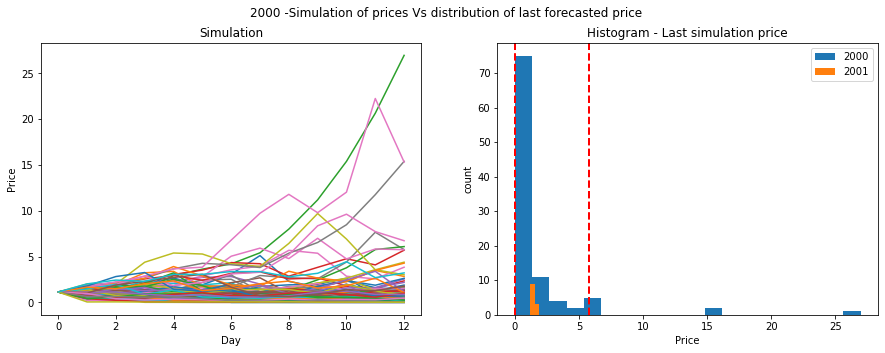

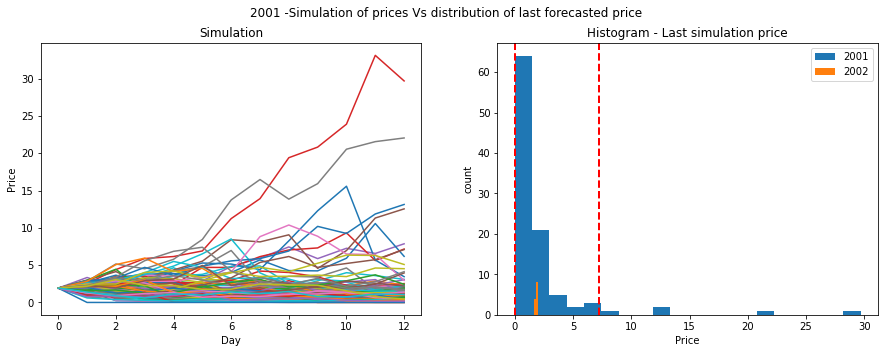

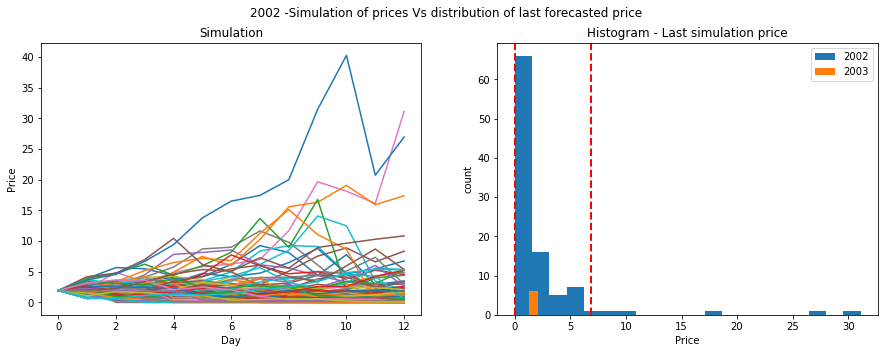

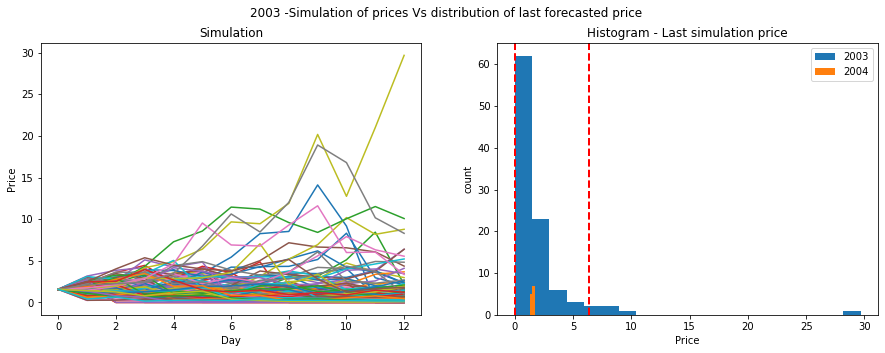

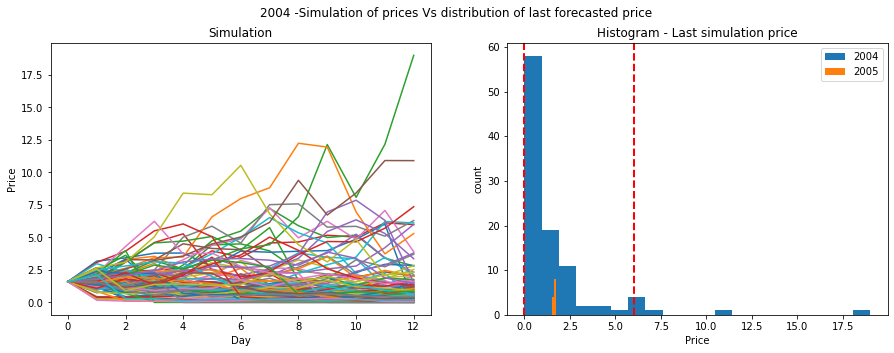

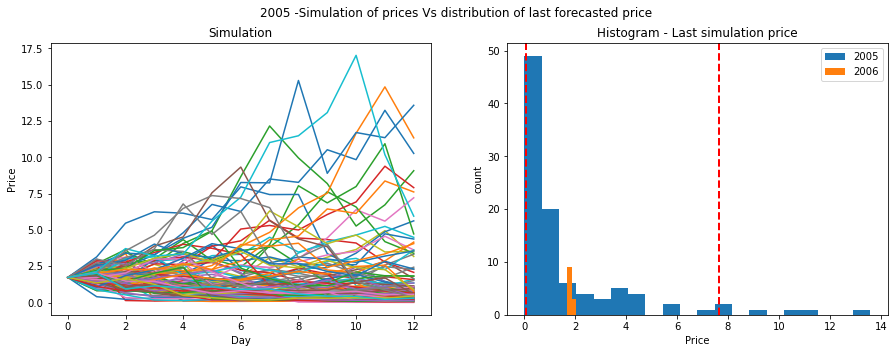

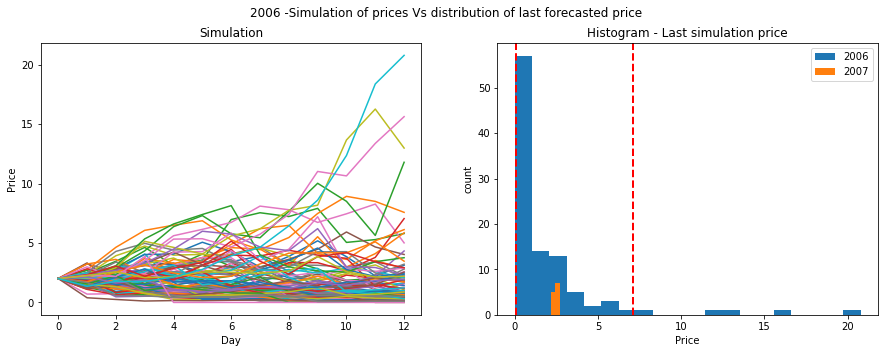

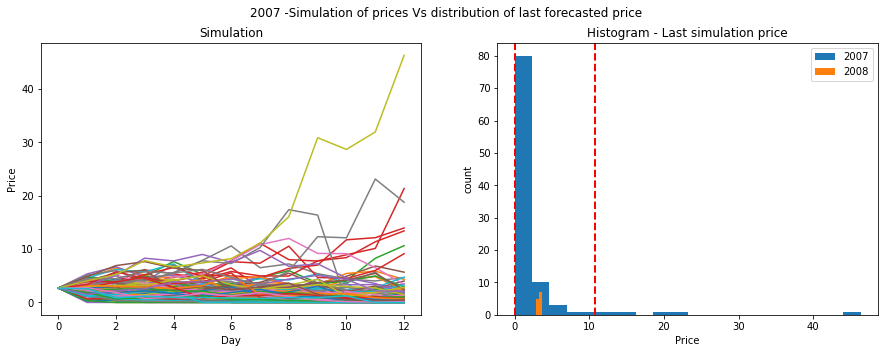

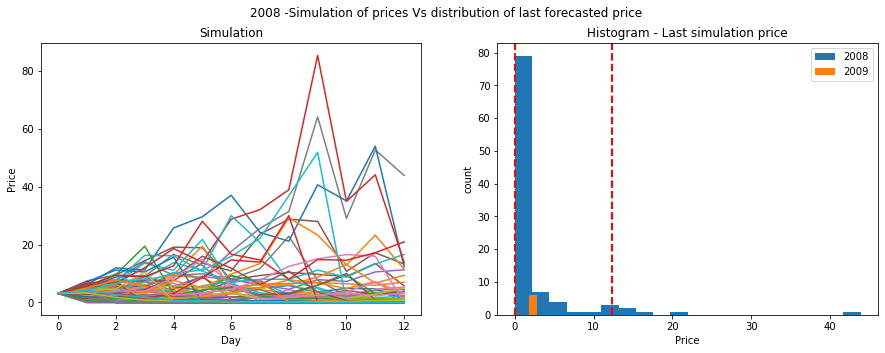

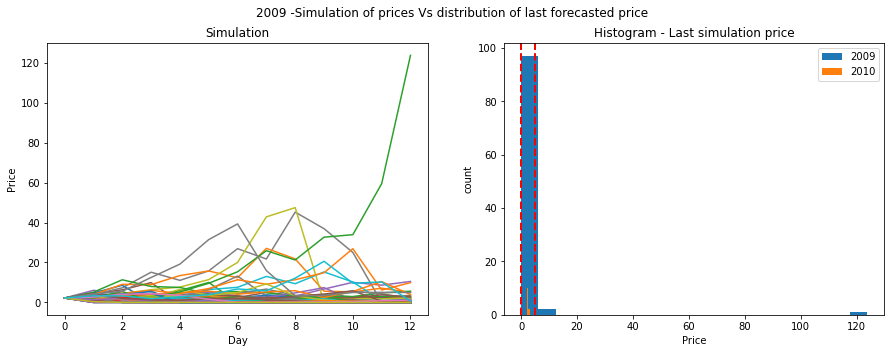

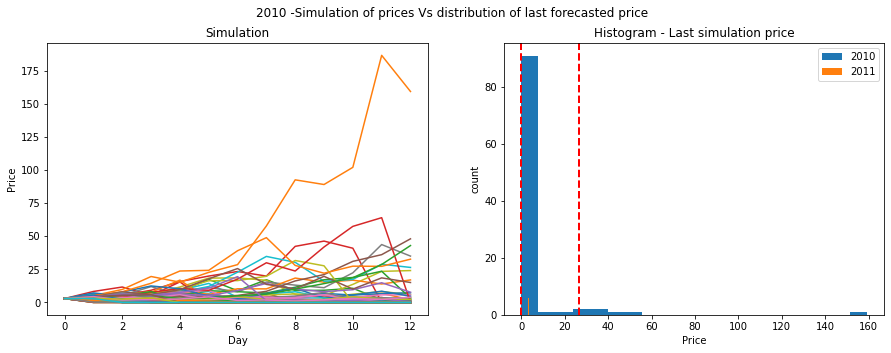

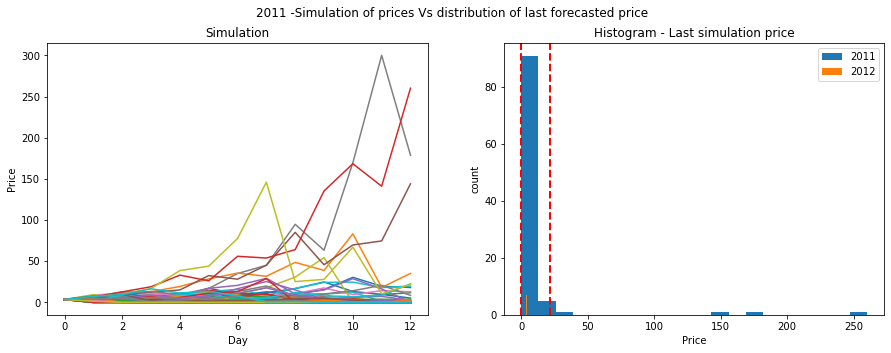

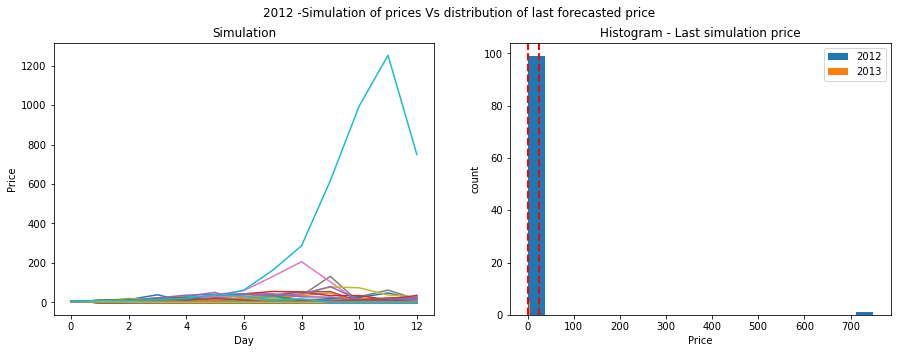

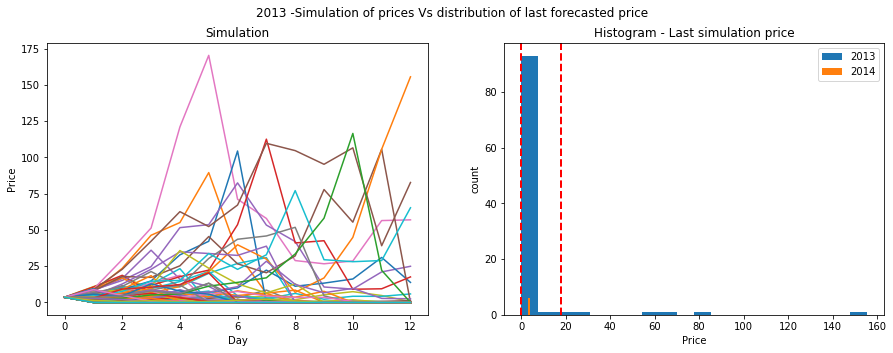

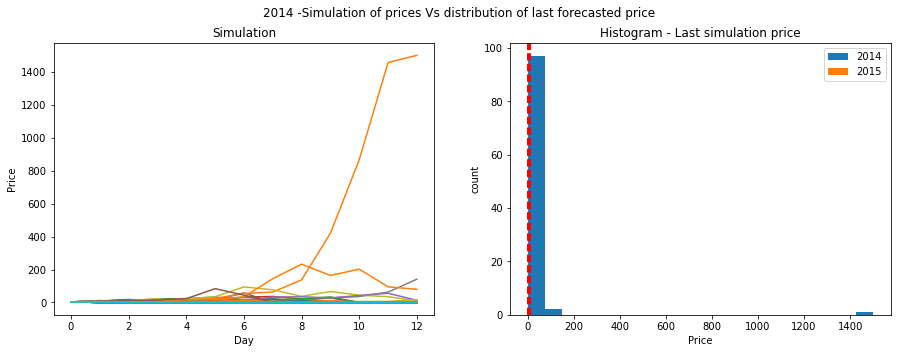

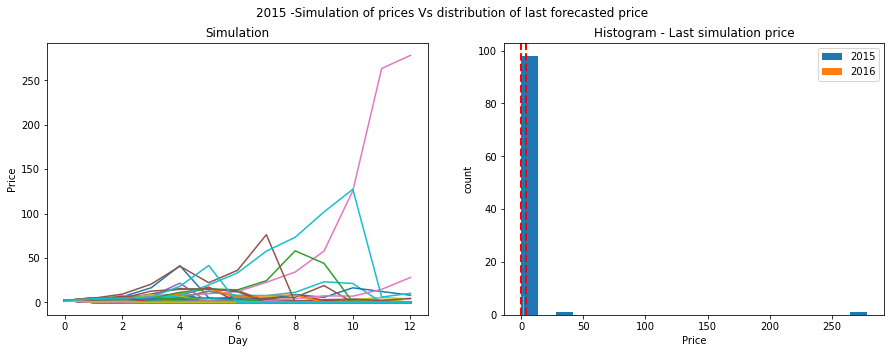

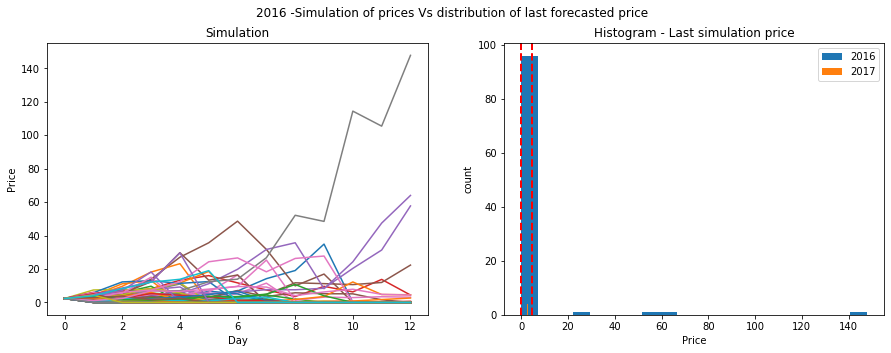

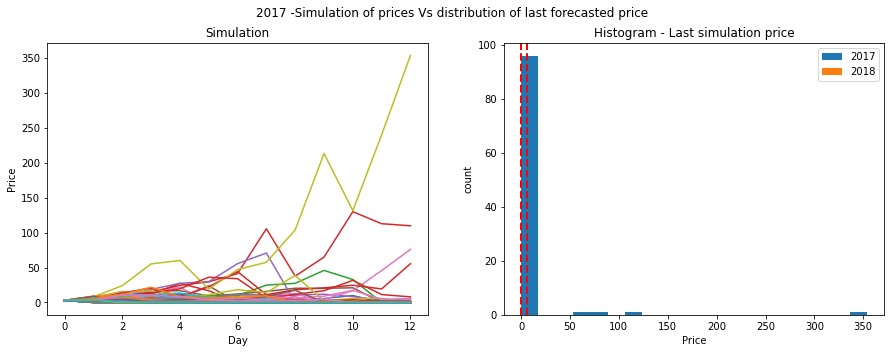

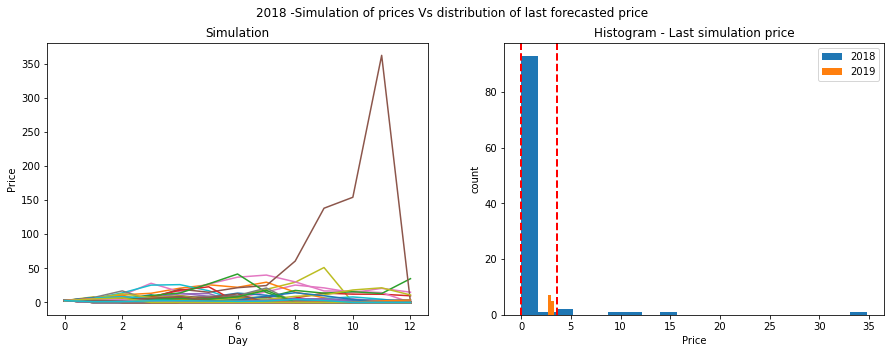

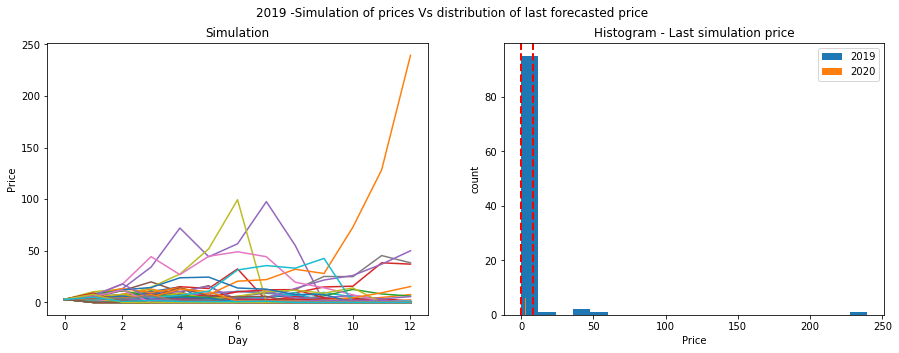

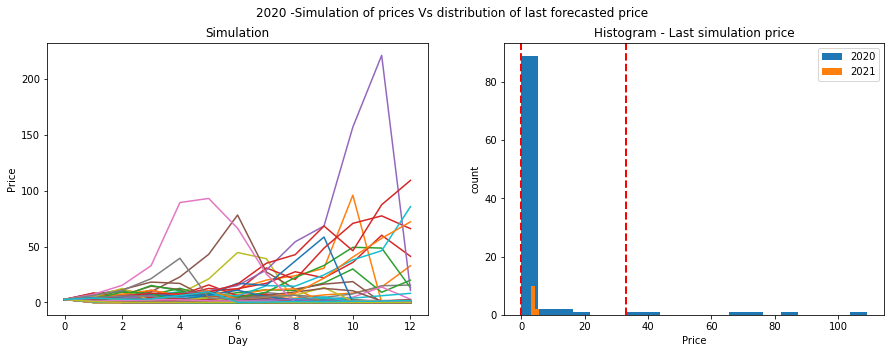

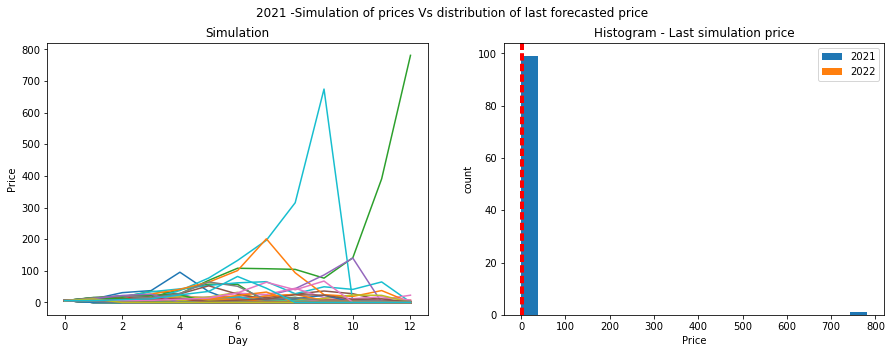

In [148]:
sim_count =  100
T = 12
# df = pd.DataFrame()
# last_price_list = []
# for x in range(NUM_SIMULATIONS):
for y in years:
    df = pd.DataFrame()
    last_price_list = []
    tempdf = random_walk_df.loc[random_walk_df.Year_ID ==y,]
#     count = 0
#     price_list = []
#     last_price = tempdf['Amount'].iloc[-1]
#     price_list.append(last_price)
#     monthly_vol = tempdf['yearly_vol'].iloc[0]

    for sim in range(sim_count):
        price_list = []
        last_price = tempdf['Amount'].iloc[-1]
        price_list.append(last_price)
        monthly_vol = tempdf['yearly_vol'].iloc[0]
        
        for t in range(T):
            prob = np.random.normal(0, monthly_vol)
            if prob <-1:
                prob = -1
            else :
                prob = prob
            price = price_list[t]* (1+prob)
            
            price_list.append(price)
            

        last_price_list.append(price_list[-1])
        df[sim] = price_list
   
#     print(len(last_price_list))
#     print(last_price_list)
    next_year_actual_prices = random_walk_df.loc[random_walk_df.Year_ID ==y+1,]['Amount'].values.tolist()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
    fig.suptitle('{} -Simulation of prices Vs distribution of last forecasted price'.format(y))
    ax1.plot(df)
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Price')
    ax1.set_title('Simulation')
    ax2.hist(last_price_list,bins=20)
    ax2.hist(next_year_actual_prices,bins=2)
    ax2.set_xlabel('Price')
    ax2.set_ylabel('count')
    labels= [y, y+1]
    ax2.legend(labels)
    ax2.set_title('Histogram - Last simulation price')
    ax2.axvline(np.percentile(last_price_list,5), color='r', linestyle='dashed', linewidth=2)
    ax2.axvline(np.percentile(last_price_list,95), color='r', linestyle='dashed', linewidth=2)

# plt.close(fig=fig)
    

        

#     fig = plt.figure()
#     fig.suptitle("Monte Carlo Simulation:year {}".format(y))
#     plt.plot(df)
#     plt.xlabel('Day')
#     plt.ylabel('Price')
#     plt.show()

## Summary
-  Data - Module4 data used in AWS was staged in bigquery. The data pertains to timeseries data for various commodities and I had take only one commodity, Oasts.
-  Model - Since data is only a time-series data, it was apposite to attempt modeling price using one of the established method, Monte-carlo simulation/random walk. The method is mentioned in the pyspark documentation on git hub https://runawayhorse001.github.io/LearningApacheSpark/mc.html#. However, since there was a pickling error when trying to create a daily matrix of returns as mentioned under 17.2.4 of the aforementioned documentation and therefore had to independently code the modelling requirement.
- Testing - The actual prices of the year subsequent to the year for which simulation was done was overlayed in the visualization. For example,  the histogram for year 2000 depicting the distribution of last simulated price has the subsquent year, 2001 prices overlayed.
- visualization - For every year,  a simulation of prices and distribution of the last simulated price from each of the 100 simulations has been visualized.The vertical red axis lines represent the 5 and 95 quintiles. The actual prices, in orange, for the subsequent year are within the 5% and 95% quintiles, indicating that the model is performing well.
